## MDI230 : Queueing theory

### Simulation Velib

#### Rémi Jaylet, Augustin Laboulet, Romain Louvet

### Imports

In [38]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import seaborn as sns

## Question 3

### Definition des paramètres

In [56]:
# Nombre de stations
S = 5

# Nombre de vélos
N = 1

# Matrice de routage
P = np.array([[0, 0.22, 0.32, 0.2, 0.26],
              [0.17, 0, 0.34, 0.21, 0.28], 
              [0.19, 0.26, 0, 0.24, 0.31], 
              [0.17, 0.22, 0.33, 0, 0.28], 
              [0.18, 0.24, 0.35, 0.23, 0]])

# Temps moyen de trajet
Tau = np.array([[0, 3, 5, 7, 7],
                [2, 0, 2, 5, 5], 
                [4, 2, 0, 3, 3], 
                [8, 6, 4, 0, 2], 
                [7, 7, 5, 2, 0]]) *60

# Taux de départ par seconde 
Lambda = np.array([2.8, 3.7, 5.5, 3.5, 4.6])/3600

#Matrice des conditions initiales
N_station_CI = np.array([20, 15, 17, 13, 18])

N_trajet_CI = np.array([[0, 1, 0, 0, 0],
                        [1, 0, 1, 0, 0], 
                        [0, 1, 0, 1, 0], 
                        [0, 0, 1, 0, 1], 
                        [0, 0, 0, 1, 0]])

CI = N_trajet_CI + np.diag(N_station_CI)

In [57]:
def lambda_itij(i, j):
    return Lambda[i] * P[i, j]
    
def lambda_tijj(i, j):
    if (i==j):
        return 0
    else :
        return 1 / Tau[i, j]

### Simulation de la trajectoire

In [58]:
def pick_state(n, somme_lambda):
    
    tirage = rd.uniform()
    prog_lambda = 0
    
    for k in range(2):
        for j in range(5):
            for i in range(5):
                if i != j :
                    prog_lambda += (lambda_itij(i, j) * (n[i, i] > 0)) if k == 0 else (lambda_tijj(i, j) * n[i, j])
                    if prog_lambda / somme_lambda > tirage:
                        return (i, i, i, j) if k == 0 else (i, j, j, j)

In [59]:
def velib(seuil):
    
    # initilisation
    etats = CI
    s1, s2, s3, s4, s5 = [N_station_CI[0]], [N_station_CI[1]], [N_station_CI[2]], [N_station_CI[3]], [N_station_CI[4]]
    time = [0]
    somme_tau = 0
    
    while somme_tau < seuil :
        somme_lambda = 0

        for i in range (5):
            for j in range(5):
                if i != j:
                    somme_lambda += lambda_itij(i, j) * (etats[i, i] > 0) + lambda_tijj(i, j) * etats[i, j]
        
        S = rd.exponential(1 / somme_lambda)
        somme_tau += S            

        # operateur de transfert
        (i_down, j_down, i_up, j_up) = pick_state(etats, somme_lambda)
        etats[i_down][j_down] -= 1
        etats[i_up][j_up] += 1
        
        # met à jour variables
        N_station = np.diag(etats)
        time.append(time[-1] + S)
        s1.append(N_station[0])
        s2.append(N_station[1])
        s3.append(N_station[2])
        s4.append(N_station[3])
        s5.append(N_station[4])

    return time, s1, s2, s3, s4, s5

### Resultats

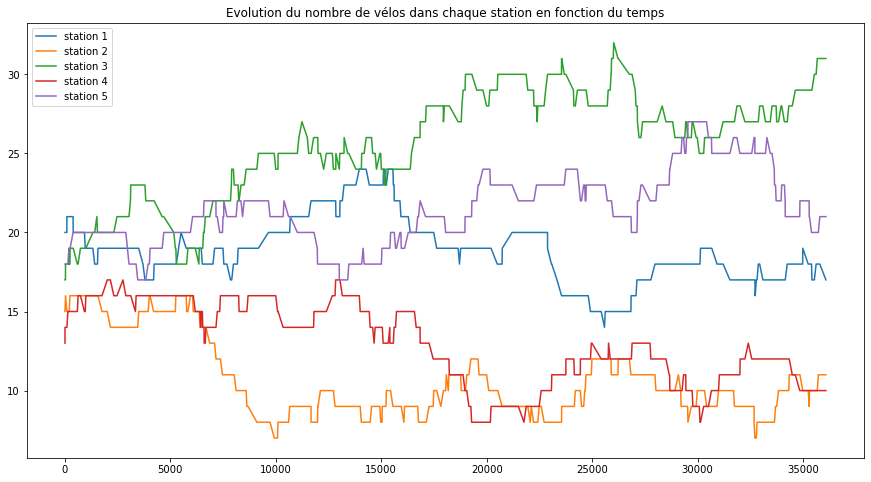

In [60]:
res = velib(36000)

time = res[0]

s1, s2, s3, s4, s5 = res[1], res[2], res[3], res[4], res[5]

plt.figure(figsize = (15,8))
plt.plot(time, s1, label = "station 1")
plt.plot(time, s2, label = "station 2")
plt.plot(time, s3, label = "station 3")
plt.plot(time, s4, label = "station 4")
plt.plot(time, s5, label = "station 5")
plt.legend()
plt.title("Evolution du nombre de vélos dans chaque station en fonction du temps")

plt.show()

## Question 4